## Курсовой проект для курса "Библиотеки Python для Data Science (продолжение)"

Задание: Используя данные из train.csv - предсказать факт невыполнения кредитных обязательств в датасете test.csv.

Датасет: train.csv, test.csv.

Целевая переменная: Credit Default.

Основная метрика: F1-score.

Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

## Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from scipy.stats import shapiro, probplot, mannwhitneyu

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

**Пусть к датасетам**

In [2]:
TRAIN_DATASET_PATH = 'Datasets/train.csv'
TEST_DATASET_PATH = 'Datasets/test.csv'

**Вспомогательные функции:**

In [3]:
## Диаграмма распределения признака со средней, медианой и модой

def show_distplot(feature, data, title, figsize):
    
    target_mean = round(data[feature].mean(), 2)
    target_median = data[feature].median()
    target_mode = data[feature].mode()[0]

    plt.figure(figsize = figsize)

    sns.distplot(data[feature], bins=70)

    plt.axvline(x=[target_mean], label='target_mean', linestyle=':',linewidth=4, color='red')
    plt.axvline(x=[target_median], label='target_median', linestyle='--', linewidth=4, color='green')
    plt.axvline(x=[target_mode], label='target_mode', linestyle='-.', linewidth=4, color='orange')
    plt.title(title)
    plt.legend()


# Метрики модели:

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    
    print(f'Train\n\n{classification_report(y_train_true, y_train_pred)}')
    print(f'Test\n\n{classification_report(y_test_true, y_test_pred)}')
    print(f'Confusion Matrix\n')
    print(pd.crosstab(y_test_true, y_test_pred))


# Валидация модели, вывод отчетов:
    
def evaluate_preds(model, y_train, y_test, train_pool, test_pool):
    
    y_train_pred = model.predict(train_pool)
    y_test_pred = model.predict(test_pool)
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

### Загрузка данных

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

### Анализ данных

**Описание датасета**

* **Home Ownership**  - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquentr** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit score** - Кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [5]:
train.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


Проверим пропуски

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

В признаках **Annual Income**, **Years in current job**, **Months since last delinquent**, **Bankruptcies**, **Credit Score** есть пропуски.

Числовые признаки

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001343FB01AC0>,
      dtype=object)

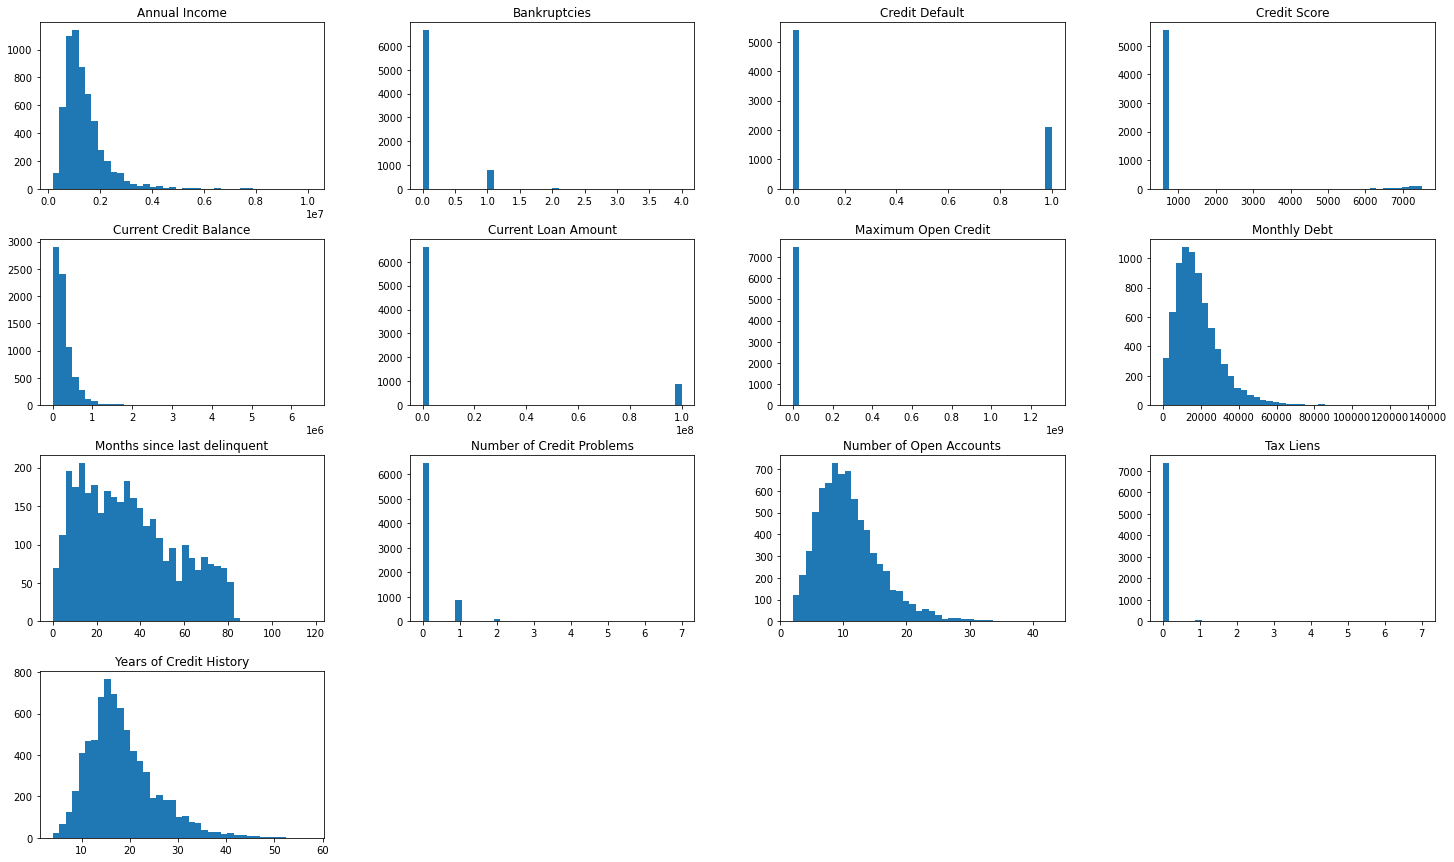

In [7]:
train.select_dtypes(exclude=['object']).hist(figsize=(25,15), bins=40, grid=False)

Обратим внимание на признаки **Credit score** и **Current Credit Balance**.

**Анализ признаков на выбросы**

In [8]:
## Credit score:

train['Credit Score'].describe().transpose()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

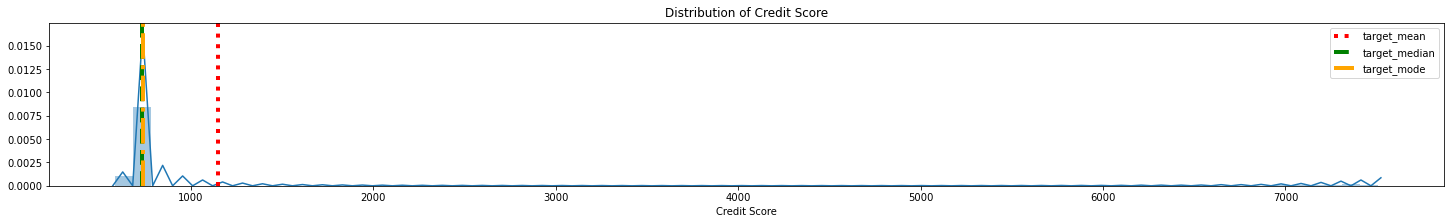

In [9]:
show_distplot(feature='Credit Score', data=train, title='Distribution of Credit Score', figsize=(25,3))

Из диаграмм выше видно, что признак имеет некоторое скопление значений в области от 6500 до 7500. Скорее всего это выбросы.

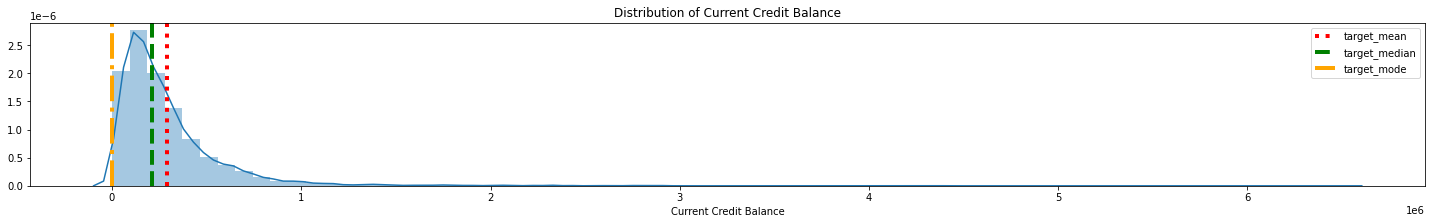

In [10]:
## Current Credit Balance:

show_distplot(feature='Current Credit Balance', data=train, title='Distribution of Current Credit Balance', figsize=(25,3))

In [11]:
train['Current Credit Balance'].describe().transpose()

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

In [12]:
train[train['Current Credit Balance'] > 2000000].shape[0]

41

In [13]:
train[train['Current Credit Balance'] > 1500000].head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
93,Home Mortgage,NaN,10+ years,0.0,18.0,17.9,3028014.0,0.0,NaN,0.0,debt consolidation,Short Term,311168.0,2327443.0,55716.0,NaN,0
162,Home Mortgage,2131591.0,< 1 year,0.0,15.0,31.7,4191176.0,0.0,NaN,0.0,debt consolidation,Short Term,269258.0,3547262.0,20783.0,728.0,0
561,Own Home,1709829.0,8 years,0.0,16.0,32.0,6230994.0,0.0,46.0,0.0,home improvements,Short Term,131978.0,1754308.0,35764.0,750.0,0
604,Home Mortgage,2822773.0,1 year,0.0,13.0,29.5,3409934.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,2612177.0,50810.0,727.0,0
814,Home Mortgage,NaN,2 years,0.0,18.0,14.2,2541088.0,0.0,NaN,0.0,debt consolidation,Short Term,470690.0,1768824.0,40954.0,NaN,1


Эти данные выглядят нормально. Оставим как есть.

**Добавим фичи**

* Current_Loan_Amount_cat: категориальный признак для Current Loan Amount
* isSusp: будем присваивать 1 наблюдениям с возрастом кредитной истории больше 55 лет и кредитным рейтингом больше 1000

**Пропуски будем заполнять регрессией**

* Annual Income
* Credit Score

Сперва заполняем в этих признаках пропуски медианой (наблюдения с пропусками помечаем отдельным признаком). Далее делаем для них категориальные признаки. При обучении модели отдаем только наблюдения, в которых не было пропусков, обучаем. После чего, выбираем помеченные наблюдения, как пропуски, и заполняем значения на основе предсказаний модели.

## Обработка данных

In [14]:
class Data:

    def __init__(self):
        
        self.medians = None
        self.model_regr_CrSc = None
        self.model_regr_AnIn = None
        
    def fit(self, df):
        
        self.medians = df[['Annual Income', 'Credit Score']].median()
    
    def fit_regr_Credit_Score(self, df):
        """Создание регрессии по Credit Score, обучение модели"""
        
        df_regr = df.copy()
        df_regr = df_regr[df_regr['Credit_Score_isnan'] == 0]
        df_regr = df_regr.drop(['Credit Default', 'Credit_Score_isnan'], axis=1)
        target_name_regr = 'Credit Score'
        feature_names_regr = df_regr.columns.drop(target_name_regr).tolist()
        feature_names_cat_regr = df_regr.select_dtypes(include=['int64', 'object']).columns.tolist()
        
        Xc = df_regr[feature_names_regr]
        yc = df_regr[target_name_regr]

        Xc_train, Xc_test, yc_train, yc_test = train_test_split(
            Xc,
            yc,
            shuffle=True,
            test_size=0.3,
            random_state=42
        )
        
        train_pool = Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr)
        test_pool = Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        
        self.model_regr_CrSc = CatBoostRegressor(
            eval_metric='R2',
            silent=True,
            one_hot_max_size=20,
            early_stopping_rounds=40,
            boosting_type='Ordered',
            allow_writing_files=False,
            depth=4,
            iterations=400,
            learning_rate=0.03,
            l2_leaf_reg=2
        )

        self.model_regr_CrSc.fit(
            Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr),
            eval_set=Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        )

        print(f'Credit Score R2: {self.model_regr_CrSc.get_best_score()}')
        del df_regr
        
    def fit_regr_Annual_Income(self, df):
        """Создание регрессии по Annual Income, обучение модели"""
        
        df_regr = df.copy()
        df_regr = df_regr[df_regr['Annual_Income_isnan'] == 0]
        df_regr = df_regr.drop(['Credit Default', 'Annual_Income_isnan'], axis=1)
        target_name_regr = 'Annual Income'
        feature_names_regr = df_regr.columns.drop(target_name_regr).tolist()
        feature_names_cat_regr = df_regr.select_dtypes(include=['int64', 'object']).columns.tolist()
        
        Xc = df_regr[feature_names_regr]
        yc = df_regr[target_name_regr]

        Xc_train, Xc_test, yc_train, yc_test = train_test_split(
            Xc,
            yc,
            shuffle=True,
            test_size=0.3,
            random_state=42
        )
        
        train_pool = Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr)
        test_pool = Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        
        self.model_regr_AnIn = CatBoostRegressor(
            eval_metric='R2',
            silent=True,
            one_hot_max_size=20,
            early_stopping_rounds=40,
            boosting_type='Ordered',
            allow_writing_files=False,
            depth=6,
            iterations=900,
            learning_rate=0.5,
            l2_leaf_reg=3.5
        )

        self.model_regr_AnIn.fit(
            Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr),
            eval_set=Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        )
        
        print(f'Annual Income R2: {self.model_regr_AnIn.get_best_score()}')
        del df_regr
    
    def apply_regr_Credit_Score(self, df):
        """Заполнение пропусков Credit Score"""
        
        cond = (df['Credit_Score_isnan'] == 1)
        Xc = df[cond].drop(['Credit Score', 'Credit Default', 'Credit_Score_isnan'], axis=1, errors='ignore')
        df.loc[cond, 'Credit Score'] = self.model_regr_CrSc.predict(Xc)
        df = df.drop(['Credit_Score_isnan', 'Credit_Score_cat'], axis=1)
        return df

    def apply_regr_Annual_Income(self, df):
        """Заполнение пропусков Annual Income"""
        
        cond = (df['Annual_Income_isnan'] == 1)
        Xc = df[cond].drop(['Annual Income', 'Credit Default', 'Annual_Income_isnan'], axis=1, errors='ignore')
        df.loc[cond, 'Annual Income'] = self.model_regr_AnIn.predict(Xc)
        df = df.drop(['Annual_Income_isnan', 'Annual_Income_cat'], axis=1)
        return df
    
    def transform(self, df):
        
        # пропуски
        df['Years in current job'].fillna('nan', inplace=True)
        df['Months since last delinquent'].fillna(0, inplace=True)
        df['Bankruptcies'].fillna(0, inplace=True)
        
        # заполнение Annual Income регрессией
        df['Annual_Income_isnan'] = 0
        df.loc[df['Annual Income'].isna(), 'Annual_Income_isnan'] = 1
        df['Annual Income'].fillna(self.medians['Annual Income'], inplace=True)
        
        # заполнение Credit Score регрессией
        df['Credit_Score_isnan'] = 0
        df.loc[df['Credit Score'].isna(), 'Credit_Score_isnan'] = 1
        df['Credit Score'].fillna(self.medians['Credit Score'], inplace=True)
        
        return df
    
    def features(self, df):
        
        # признак подозрительных наблдений
        df = self.feature_isSusp(df)
        
        # признак с кредитным рейтингом
        # используется при регрессии, далее удаляется
        df = self.credit_score_to_cat(df)
        
        # признак с текущей суммой кредита, разбитой на категории
        df = self.current_loan_amount_to_cat(df)
        
        # признак с годовым доходом, разбитым на категории
        # используется при регрессии, далее удаляется
        df = self.annual_income_to_cat(df)
        
        columns_to_int = ['Tax Liens', 'Bankruptcies', 'Number of Credit Problems']
        df[columns_to_int] = df[columns_to_int].astype(int)
        
        return df
    
    @staticmethod
    def credit_score_to_cat(df):
        """Создание признака Credit_Score_cat"""
        
        df['Credit_Score_cat'] = np.nan
        
        df.loc[df['Credit Score'] < 600, 'Credit_Score_cat'] = 1
        df.loc[(df['Credit Score'] >= 600) & (df['Credit Score'] < 650), 'Credit_Score_cat'] = 2
        df.loc[(df['Credit Score'] >= 650) & (df['Credit Score'] < 700), 'Credit_Score_cat'] = 3
        df.loc[(df['Credit Score'] >= 700) & (df['Credit Score'] < 725), 'Credit_Score_cat'] = 4
        df.loc[(df['Credit Score'] >= 725) & (df['Credit Score'] < 735), 'Credit_Score_cat'] = 5
        df.loc[(df['Credit Score'] >= 735) & (df['Credit Score'] < 745), 'Credit_Score_cat'] = 6
        df.loc[(df['Credit Score'] >= 745) & (df['Credit Score'] < 755), 'Credit_Score_cat'] = 7
        df.loc[df['Credit Score'] >= 755, 'Credit_Score_cat'] = 8
        
        df['Credit_Score_cat'] = df['Credit_Score_cat'].astype(int)
        
        return df
    
    @staticmethod
    def current_loan_amount_to_cat(df):
        """Создание признака Current_Loan_Amount_cat"""
        
        df['Current_Loan_Amount_cat'] = np.nan
        
        df.loc[df['Current Loan Amount'] < 100000, 'Current_Loan_Amount_cat'] = 1
        df.loc[(df['Current Loan Amount'] >= 100000) & (df['Current Loan Amount'] < 150000), 'Current_Loan_Amount_cat'] = 2
        df.loc[(df['Current Loan Amount'] >= 150000) & (df['Current Loan Amount'] < 250000), 'Current_Loan_Amount_cat'] = 3
        df.loc[(df['Current Loan Amount'] >= 250000) & (df['Current Loan Amount'] < 300000), 'Current_Loan_Amount_cat'] = 4
        df.loc[(df['Current Loan Amount'] >= 300000) & (df['Current Loan Amount'] < 325000), 'Current_Loan_Amount_cat'] = 5
        df.loc[(df['Current Loan Amount'] >= 325000) & (df['Current Loan Amount'] < 350000), 'Current_Loan_Amount_cat'] = 6
        df.loc[(df['Current Loan Amount'] >= 350000) & (df['Current Loan Amount'] < 400000), 'Current_Loan_Amount_cat'] = 7
        df.loc[(df['Current Loan Amount'] >= 400000) & (df['Current Loan Amount'] < 450000), 'Current_Loan_Amount_cat'] = 8
        df.loc[(df['Current Loan Amount'] >= 450000) & (df['Current Loan Amount'] < 500000), 'Current_Loan_Amount_cat'] = 9
        df.loc[df['Current Loan Amount'] >= 500000, 'Current_Loan_Amount_cat'] = 10
        
        df['Current_Loan_Amount_cat'] = df['Current_Loan_Amount_cat'].astype(int)
        
        return df

    @staticmethod
    def annual_income_to_cat(df):
        """Создание признака Annual_Income_cat"""
        
        df['Annual_Income_cat'] = np.nan
        
        df.loc[df['Annual Income'] < 500000, 'Annual_Income_cat'] = 1
        df.loc[(df['Annual Income'] >= 500000) & (df['Annual Income'] < 750000), 'Annual_Income_cat'] = 2
        df.loc[(df['Annual Income'] >= 750000) & (df['Annual Income'] < 1000000), 'Annual_Income_cat'] = 3
        df.loc[(df['Annual Income'] >= 1000000) & (df['Annual Income'] < 1125000), 'Annual_Income_cat'] = 4
        df.loc[(df['Annual Income'] >= 1125000) & (df['Annual Income'] < 1250000), 'Annual_Income_cat'] = 5
        df.loc[(df['Annual Income'] >= 1250000) & (df['Annual Income'] < 1500000), 'Annual_Income_cat'] = 6
        df.loc[(df['Annual Income'] >= 1500000) & (df['Annual Income'] < 1750000), 'Annual_Income_cat'] = 7
        df.loc[(df['Annual Income'] >= 1750000) & (df['Annual Income'] < 2000000), 'Annual_Income_cat'] = 8
        df.loc[(df['Annual Income'] >= 2000000) & (df['Annual Income'] < 2500000), 'Annual_Income_cat'] = 9
        df.loc[df['Annual Income'] >= 2500000, 'Annual_Income_cat'] = 10
        
        df['Annual_Income_cat'] = df['Annual_Income_cat'].astype(int)
        
        return df
    
    @staticmethod
    def feature_isSusp(df):
        """Признак подозрительных наблюдений"""
        
        df['isSusp'] = 0
        df.loc[df['Years of Credit History'] > 55, 'isSusp'] = 1
        df.loc[df['Credit Score'] > 1000, 'isSusp'] = 1
        
        return df

## Инициализация класса

In [15]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

data_inst = Data()

# тренировочный датасет
data_inst.fit(train)
df_train = data_inst.transform(train)
df_train = data_inst.features(df_train)

# регрессия Credit Score
data_inst.fit_regr_Credit_Score(df_train)
df_train = data_inst.apply_regr_Credit_Score(df_train)

# регрессия Annual Income
data_inst.fit_regr_Annual_Income(df_train)
df_train = data_inst.apply_regr_Annual_Income(df_train)

# тестовый датасет
df_test = data_inst.transform(test)
df_test = data_inst.features(df_test)
df_test = data_inst.apply_regr_Credit_Score(df_test)
df_test = data_inst.apply_regr_Annual_Income(df_test)

target_name = 'Credit Default'
feature_names = df_train.columns.drop(target_name).tolist()
feature_names_num = df_train.select_dtypes(include='float64').columns.tolist()
feature_names_cat = df_train.select_dtypes(include=['int32', 'int64', 'object']).columns.drop(target_name).tolist()

Credit Score R2: {'learn': {'R2': 0.998345914489616, 'RMSE': 66.77692030178164}, 'validation': {'R2': 0.99801413564596, 'RMSE': 67.37174903154758}}
Annual Income R2: {'learn': {'R2': 0.9239655949050914, 'RMSE': 228917.7880191751}, 'validation': {'R2': 0.8373878567502362, 'RMSE': 354633.11758766376}}


## Корреляция признаков с целевой переменной

Text(0.5, 1.0, 'Correlation with target variable')

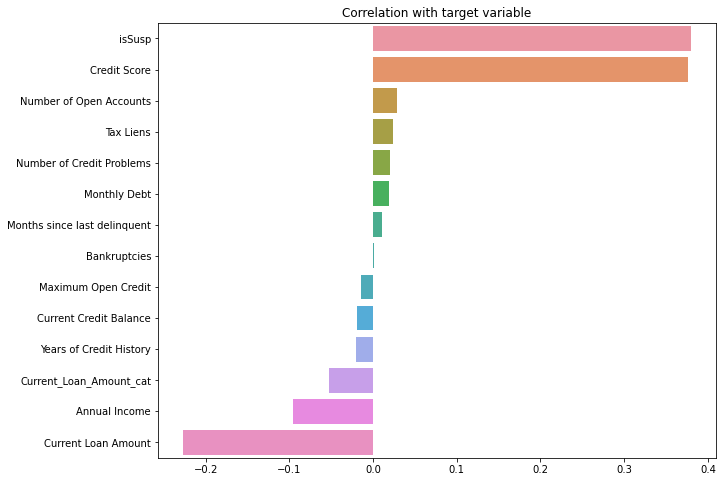

In [16]:
corr_with_target = df_train[feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')

**Корреляция признака Credit Score с целевой переменной в разрезе классов:**

Text(0.5, 1.0, 'Credit Score grouped by target variable')

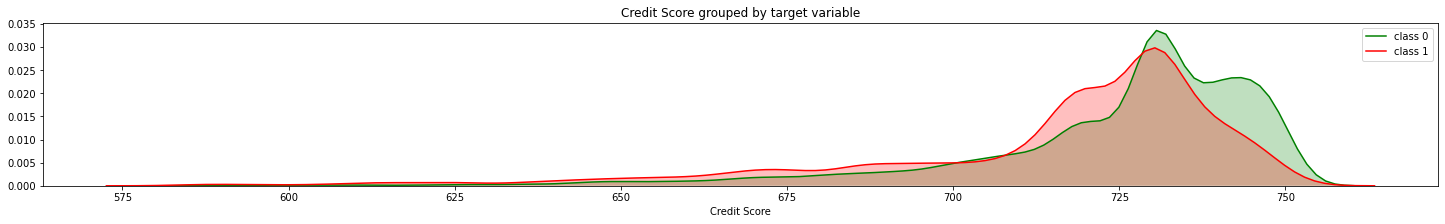

In [17]:
credit_score_with_target = df_train[df_train['Credit Score'] < 1000][['Credit Score', target_name]]
credit_score = credit_score_with_target['Credit Score']
credit_score_target_0 = credit_score[credit_score_with_target[target_name] == 0]
credit_score_target_1 = credit_score[credit_score_with_target[target_name] == 1]

plt.figure(figsize=(25, 3))

sns.kdeplot(credit_score_target_0, shade=True, label='class 0', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='class 1', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')

**Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка:**

In [18]:
shapiro(credit_score)

ShapiroResult(statistic=0.82184898853302, pvalue=0.0)

Распределение не нормально, так как значение p-value меньше 0.05.

((array([-3.72509304, -3.49508022, -3.36856895, ...,  3.36856895,
          3.49508022,  3.72509304]),
  array([585., 586., 588., ..., 751., 751., 751.])),
 (22.422754836390528, 722.2506025741355, 0.9065532145807904))

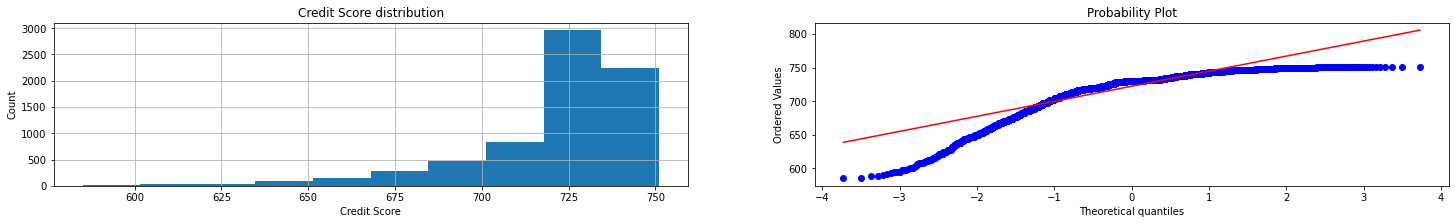

In [19]:
plt.figure(figsize=(25, 3))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
credit_score.hist()

plt.subplot(122)
probplot(credit_score, dist='norm', plot=plt)

Графическое представление подтверждает, что распределение отлично от "нормального"

**Оценка эквивалентности математических ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни**

In [20]:
mannwhitneyu(credit_score_target_0, credit_score_target_1)

MannwhitneyuResult(statistic=3444824.0, pvalue=1.0844079762547325e-56)

Гипотеза о равности математических ожиданий не верна, так как значение p-value меньше 0.05.

Text(0.5, 1.0, 'Confidence intervals (95 %) for Credit Score')

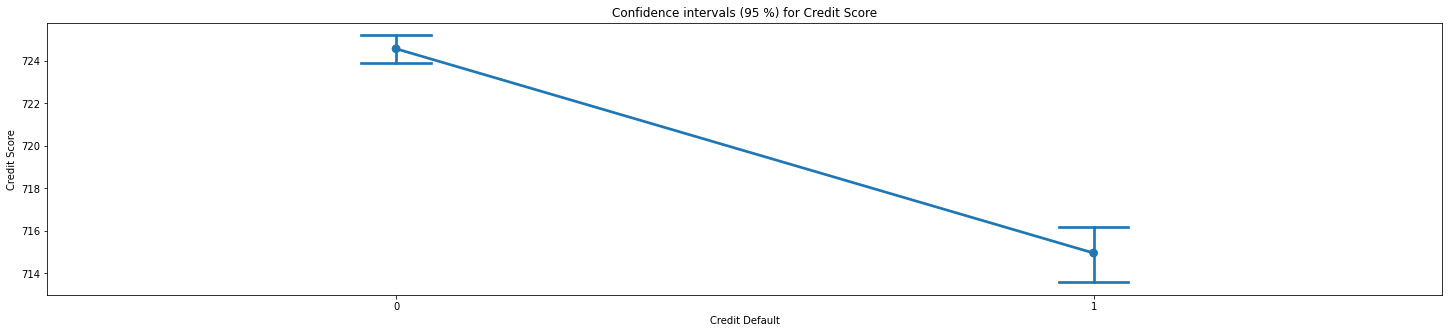

In [21]:
plt.figure(figsize=(25, 5))

sns.pointplot(x=target_name, y='Credit Score', data=credit_score_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')

Математические ожидания не пересекается.

**Матрица корреляций**

Text(0.5, 1.0, 'Correlation matrix')

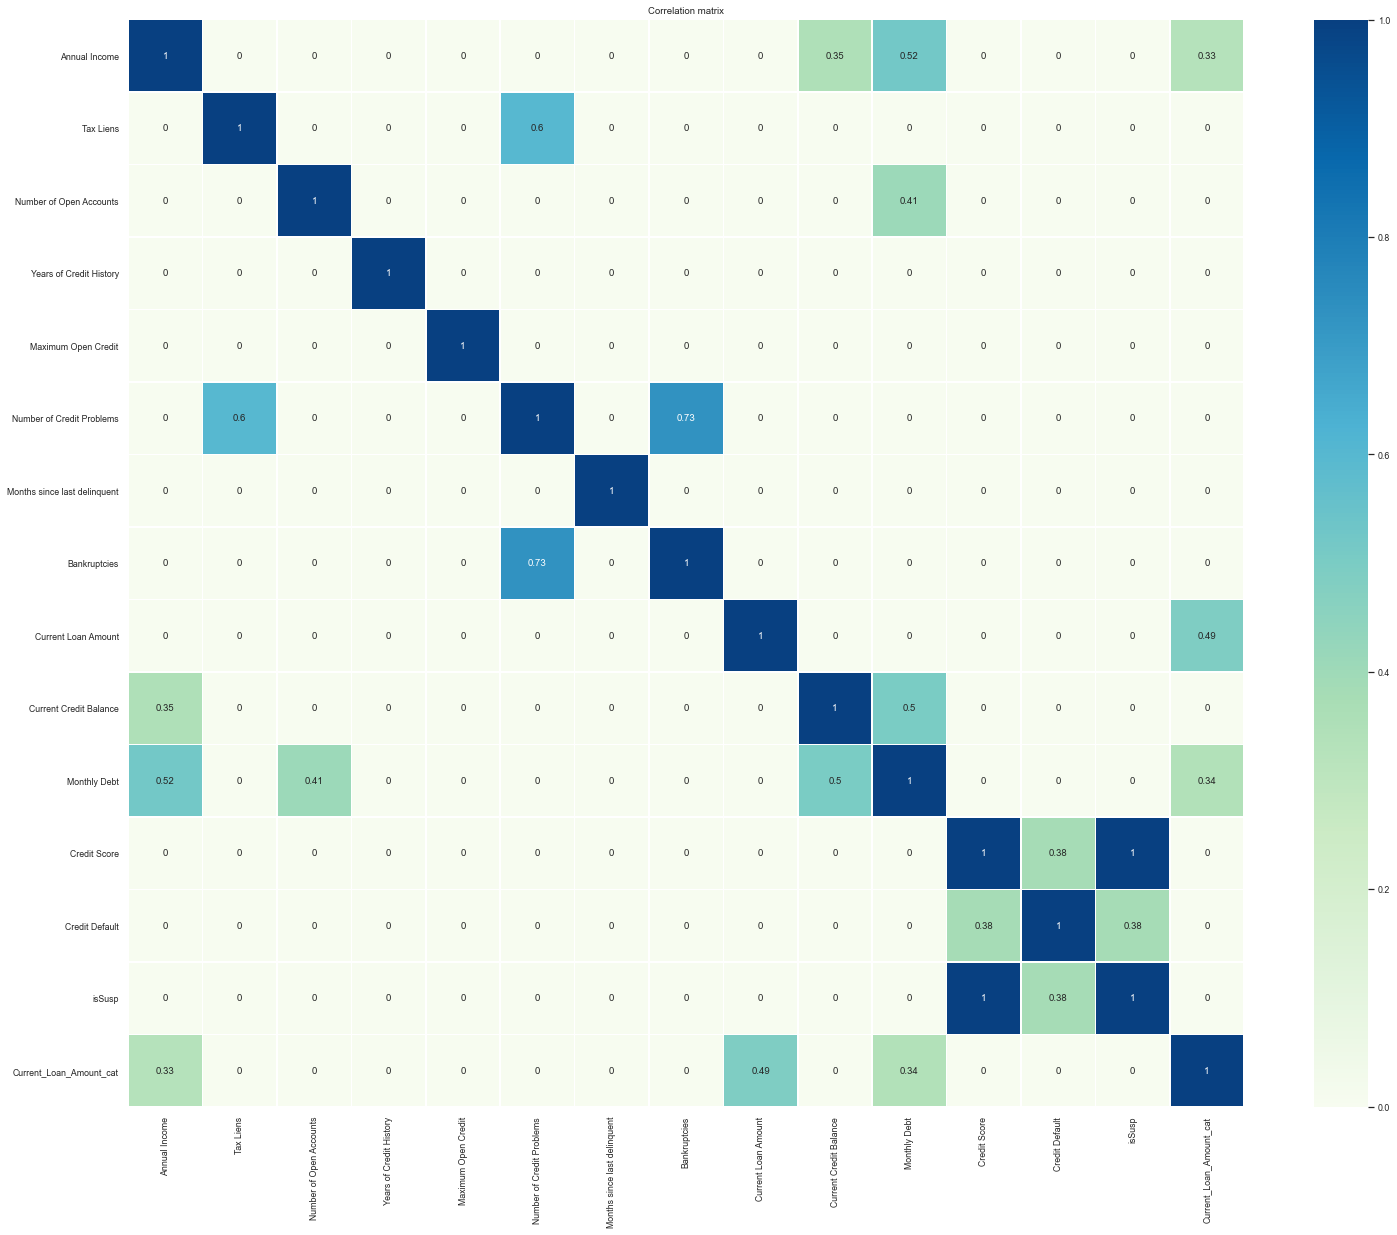

In [22]:
plt.figure(figsize = (25,20))

sns.set(font_scale=0.8)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')

### Разбиение обучающего датасета на train и test

In [23]:
X = df_train[feature_names]
y = df_train[target_name]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=True,
    test_size=0.3,
    random_state=42,
    stratify=y
)

**Проверка распределения вещественных признаков на X_train и X_test**

Annual Income: 0.044
Number of Open Accounts: 0.303
Years of Credit History: 0.379
Maximum Open Credit: 0.452
Months since last delinquent: 0.311
Current Loan Amount: 0.119
Current Credit Balance: 0.382
Monthly Debt: 0.05
Credit Score: 0.286


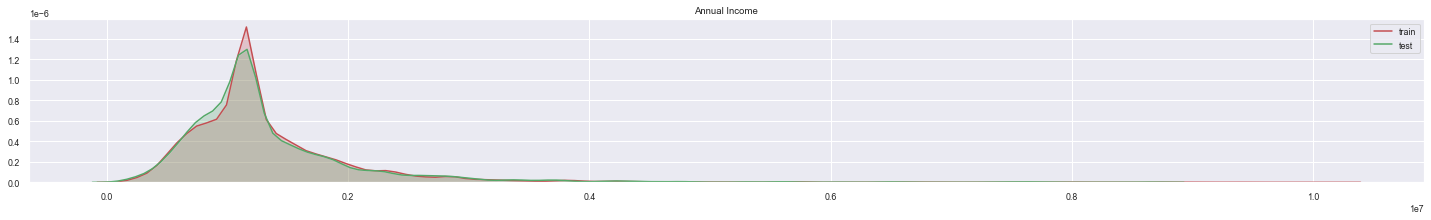

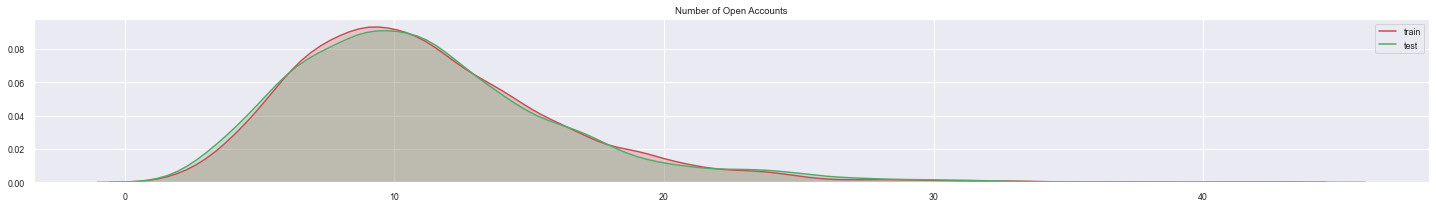

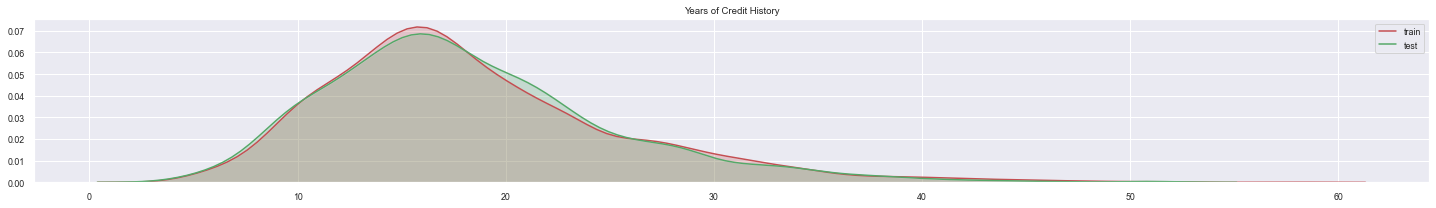

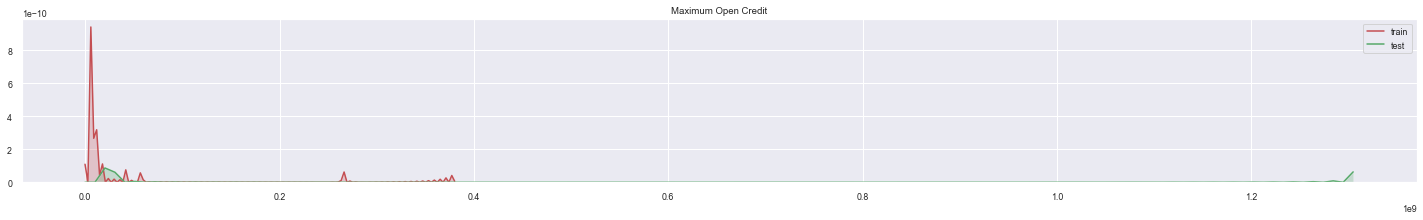

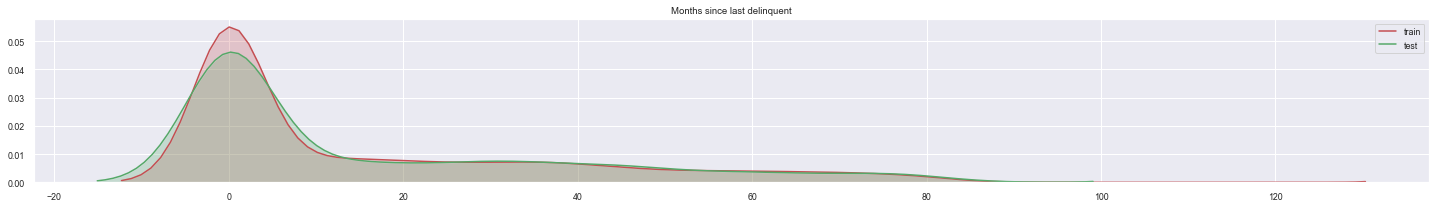

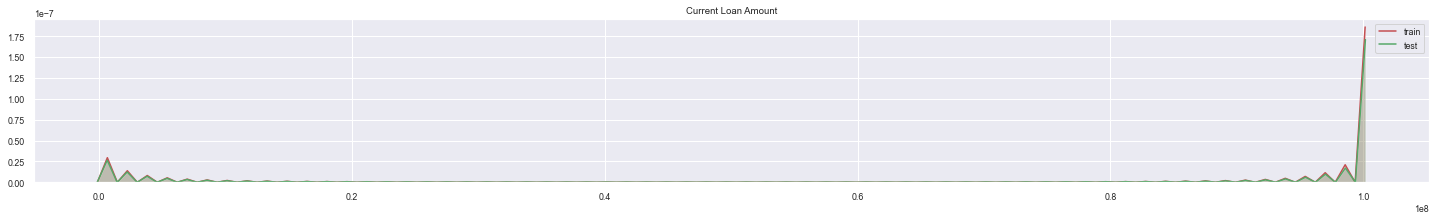

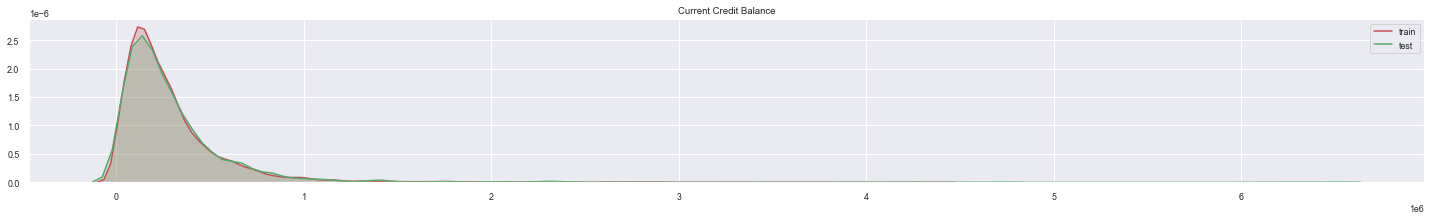

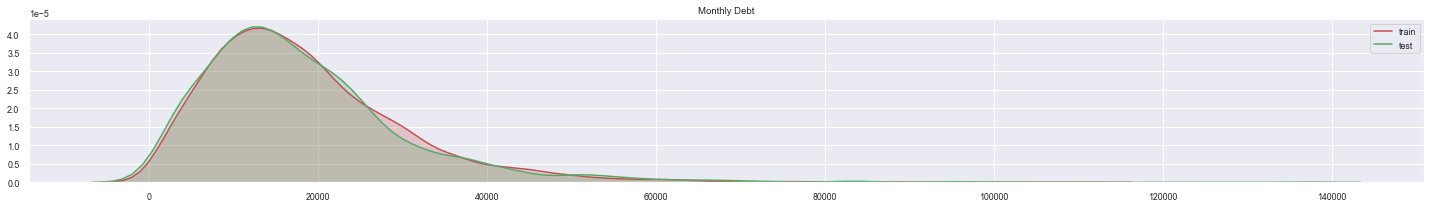

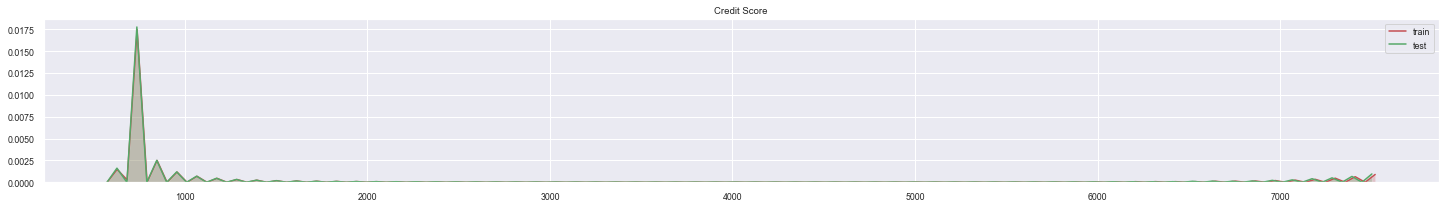

In [24]:
for col in feature_names_num:
    print(col + ': ' + str(round(mannwhitneyu(X_train[col], X_test[col])[1], 3)))
    plt.figure(figsize=(25, 3))
    sns.set(font_scale=0.8)
    sns.kdeplot(X_train[col], shade=True, label='train', color='r')
    sns.kdeplot(X_test[col], shade=True, label='test', color='g')
    plt.title(col)

**Проверка распределения категориальных признаков на X_train и X_test**

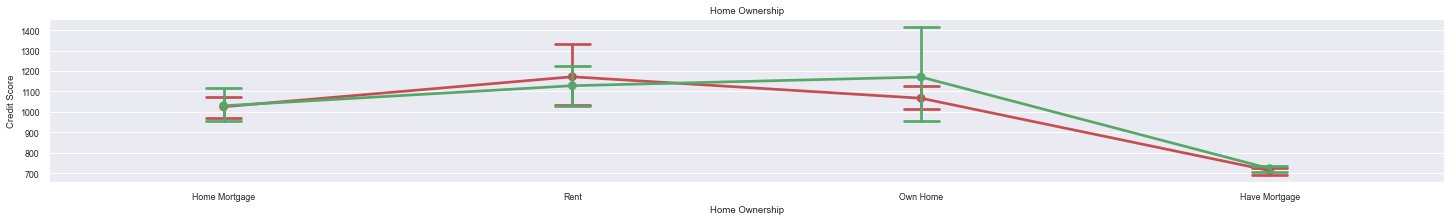

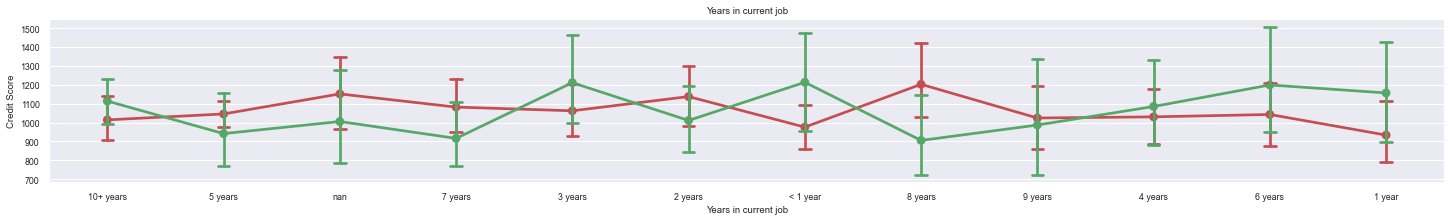

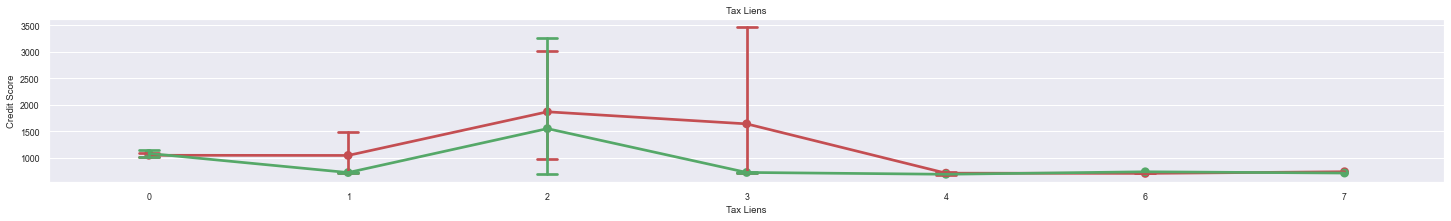

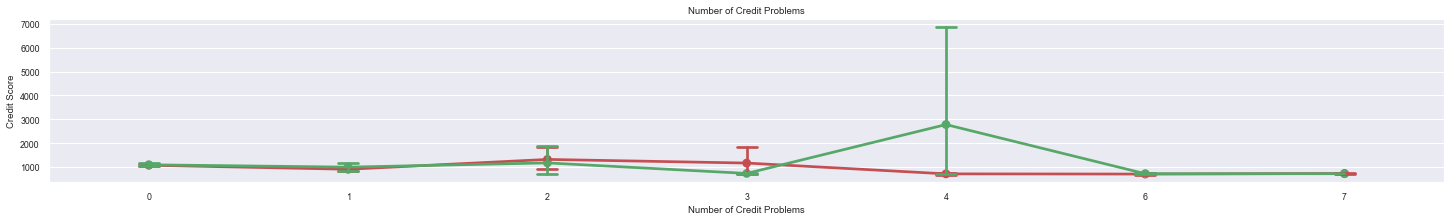

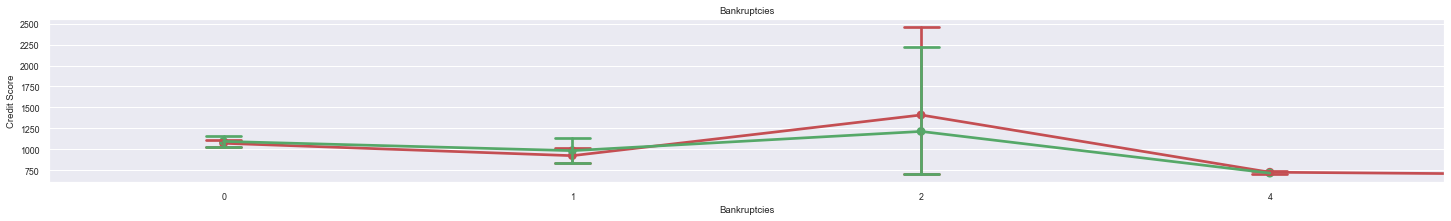

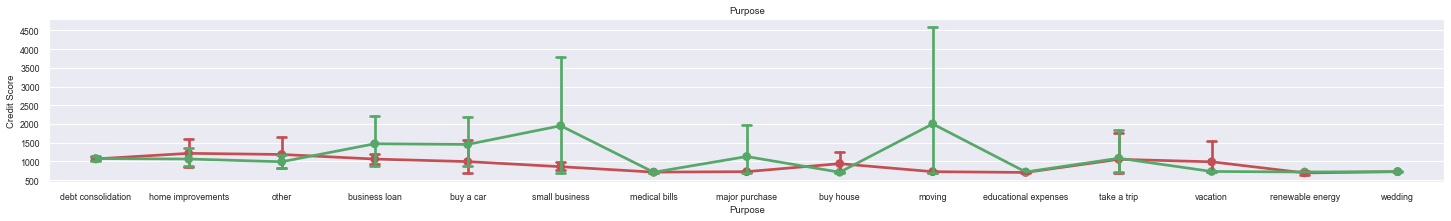

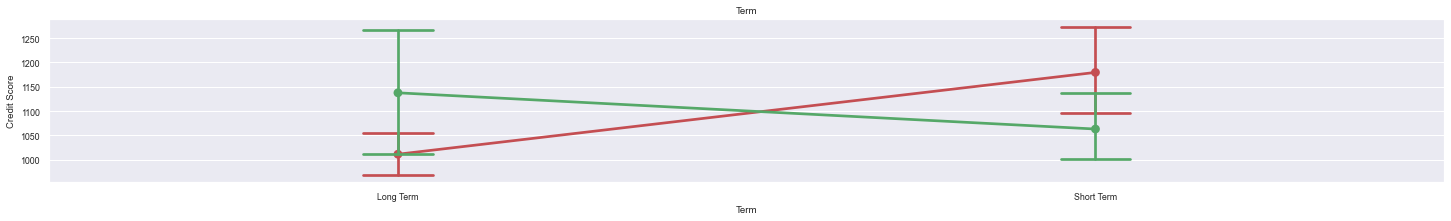

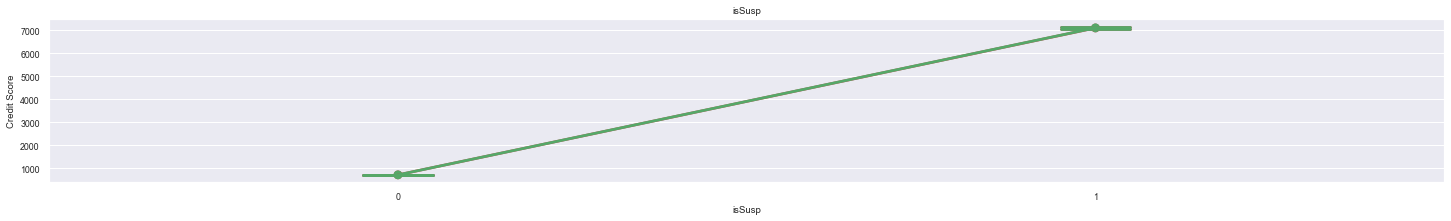

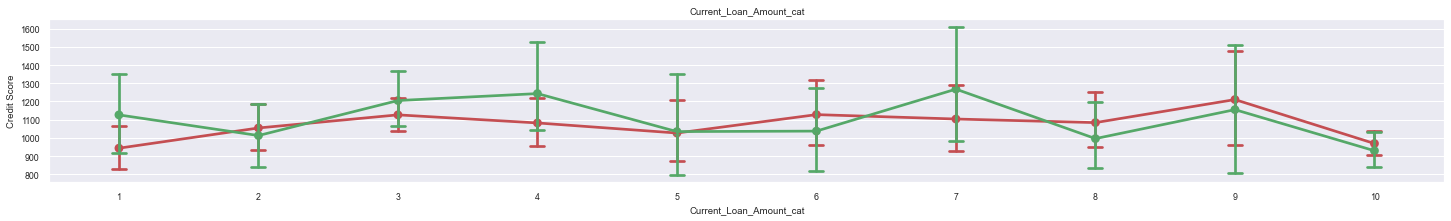

In [25]:
num_feature = 'Credit Score'
for col in feature_names_cat:
    plt.figure(figsize=(25, 3))
    sns.pointplot(x=col, y=num_feature, data=X_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=X_test, capsize=.1, label='test', color='g')
    plt.title(col)

### Обучение модели

**Определение максимального количества уникальных значений среди категориальных признаков**

In [26]:
sorted([X_train[feature_names_cat][col].nunique() for col in feature_names_cat])[-1]

15

##### **Определение гиперпараметров:**

Константные параметры:

* **eval_metric = 'F1'** - метрика
* **auto_class_weights = 'Balanced'** - автоматический подбор весов для балансировки классов
* **silent = True** - блокирование лишнего вывода логов
* **cat_features = feature_names_cat** - категориальные признаки
* **one_hot_max_size = 15**  - определяли выше
* **early_stopping_rounds = 50** - отслеживание переобучения
* **boosting_type = 'Ordered'** - дает лучше результат на небольших датасетах

Подбираемые параметры:

* depth
* learning_rate
* iterations
* bagging_temperature

In [27]:
train_pool = Pool(
    X_train,
    y_train,
    cat_features=feature_names_cat
)

test_pool = Pool(
    X_test,
    y_test,
    cat_features=feature_names_cat
) 

params_model = {
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 50,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

**Код определения гиперпараметров**

In [28]:
%%time

cbr_model = CatBoostClassifier(**params_model)

params_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.03, 0.1, 0.3, 0.5],
    'iterations': [100, 200, 400],
    'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2]
}

gs = cbr_model.randomized_search(
    params_grid,
    train_pool,
    n_iter=20,
    shuffle=True,
    stratified=True,
    partition_random_seed=42,
    cv=5
)

gs

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6861942302
bestIteration = 0

0:	loss: 0.6861942	best: 0.6861942 (0)	total: 705ms	remaining: 13.4s

bestTest = 0.6847670993
bestIteration = 80

1:	loss: 0.6847671	best: 0.6861942 (0)	total: 5.09s	remaining: 45.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6848660927
bestIteration = 14

2:	loss: 0.6848661	best: 0.6861942 (0)	total: 8.43s	remaining: 47.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.679609479
bestIteration = 2

3:	loss: 0.6796095	best: 0.6861942 (0)	total: 11.3s	remaining: 45.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6786123754
bestIteration = 28

4:	loss: 0.6786124	best: 0.6861942 (0)	total: 15.2s	remaining: 45.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7078600468
bestIteration = 98

5:	loss: 0.7078600	best: 0.7078600 (5)	total: 37.7s	remaining: 1m 27s
Stopped by overfitting detector  (50 iterations 

{'params': {'bagging_temperature': 1,
  'depth': 10,
  'l2_leaf_reg': 3,
  'iterations': 400,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
        

### Обучение финальной модели

**Подобранные гиперпараметры**

In [29]:
depth=6,
iterations=100,
learning_rate=0.5,
l2_leaf_reg=3.5,
bagging_temperature=1.5

**Обучение с подобранными гиперпараметрами**

In [30]:
%%time

cbr_final_model = CatBoostClassifier(
    **params_model,
    depth=6,
    iterations=100,
    learning_rate=0.5,
    l2_leaf_reg=3.5,
    bagging_temperature=1.5
)

cbr_final_model.fit(train_pool, eval_set=test_pool)

Wall time: 1.17 s


**Результаты**

In [31]:
evaluate_preds(cbr_final_model, y_train, y_test, train_pool, test_pool)

Train

              precision    recall  f1-score   support

           0       0.87      0.74      0.80      3771
           1       0.52      0.73      0.61      1479

    accuracy                           0.74      5250
   macro avg       0.70      0.73      0.71      5250
weighted avg       0.78      0.74      0.75      5250

Test

              precision    recall  f1-score   support

           0       0.84      0.71      0.77      1616
           1       0.47      0.67      0.55       634

    accuracy                           0.70      2250
   macro avg       0.66      0.69      0.66      2250
weighted avg       0.74      0.70      0.71      2250

Confusion Matrix

col_0              0    1
Credit Default           
0               1142  474
1                210  424


**Веса признаков**

In [32]:
feature_importances = pd.DataFrame(
    zip(X.columns, cbr_final_model.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(20)

,feature_name,importance
16,isSusp,32.484816
12,Current Loan Amount,25.951296
15,Credit Score,9.300117
11,Term,6.676312
1,Annual Income,5.879996
6,Maximum Open Credit,4.426080
14,Monthly Debt,3.278987
13,Current Credit Balance,2.334332
5,Years of Credit History,2.022218
0,Home Ownership,1.968145


**Сохранение результатов предсказаний финальной модели**

In [35]:
y_test_pred = cbr_final_model.predict(df_test)

preds_final = pd.DataFrame()
preds_final = pd.DataFrame({'Id': np.arange(0,y_test_pred.shape[0]), 'Credit Default': y_test_pred})
preds_final.to_csv('./RodimovG_predictions.csv', index=False, encoding='utf-8', sep=',')
preds_final.head(10)

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
5,5,0
6,6,1
7,7,1
8,8,1
9,9,0
